In [1]:
from utils import *

/home/romh/miniconda3/envs/cluster/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#SETUP
LINE_WIDTH = 3
SMALL_SIZE = 15
SMALLER_SIZE = 12
MEDIUM_SIZE = 22
BIG_SIZE = 20
BIGGER_SIZE = 25
ALPHA = 0.3

plt.rc('font', size=MEDIUM_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)  # fontsize of the axes title
plt.rc('xtick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=BIG_SIZE)  # legend fontsize
plt.rc('figure', titlesize=SMALLER_SIZE)  # fontsize of the figure title
plt.rcParams['axes.axisbelow'] = True

In [3]:
results_path = 'results/'
result_files = os.listdir(results_path)
print(result_files)
thresh = 0.5

['bert-base-uncased_toxic_classification_FGSM_0.25_results.pkl', 'bert-base-uncased_toxic_classification_FGSM_0.01_results.pkl', 'bert-base-uncased_toxic_classification_FGSM_0.1_results.pkl', 'bert-base-uncased_toxic_classification_FGSM_1.0_results.pkl', 'bert-base-uncased_toxic_classification_FGSM_0.5_results.pkl', 'bert-base-uncased_toxic_classification_FGSM_2.0_results.pkl', 'bert-base-uncased_toxic_classification_FGSM_4.0_results.pkl', 'bert-base-uncased_toxic_classification_FGSM_8.0_results.pkl', 'bert-base-uncased_toxic_classification_PGD_0.5_results.pkl', 'bert-base-uncased_toxic_classification_PGD_0.01_results.pkl', 'bert-base-uncased_toxic_classification_PGD_0.1_results.pkl', 'bert-base-uncased_toxic_classification_PGD_0.25_results.pkl', 'bert-base-uncased_toxic_classification_PGD_1.0_results.pkl', 'bert-base-uncased_toxic_classification_PGD_2.0_results.pkl', 'bert-base-uncased_toxic_classification_PGD_4.0_results.pkl', 'bert-base-uncased_toxic_classification_PGD_8.0_results.p

# FGSM Alphas Results

In [4]:
# load pickled results
FGSM_results = []
FGSM_results_files = []
for result_file in result_files:
    if 'FGSM' in result_file and 'bert-base-uncased' in result_file:
        with open(results_path + result_file, 'rb') as f:
            FGSM_results.append(pickle.load(f))
            FGSM_results_files.append(result_file)

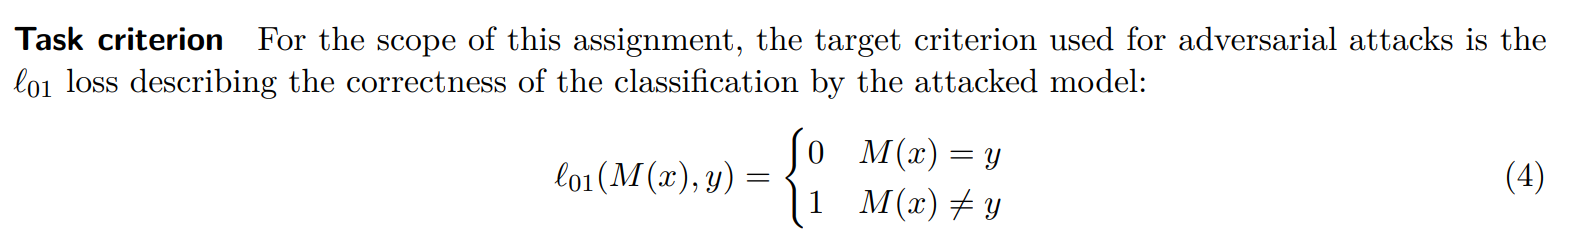

alpha: 0.25, ASR: 0.6891807379612258, accuracy: 0.31081926203877425, recall: 0.37777777777777777
alpha: 0.01, ASR: 0.3505315822388993, accuracy: 0.6494684177611006, recall: 0.9623931623931624
alpha: 0.1, ASR: 0.35068792995622267, accuracy: 0.6493120700437773, recall: 0.9623931623931624
alpha: 1.0, ASR: 0.6701063164477798, accuracy: 0.32989368355222015, recall: 0.4735042735042735
alpha: 0.5, ASR: 0.7409318323952471, accuracy: 0.259068167604753, recall: 0.4324786324786325
alpha: 2.0, ASR: 0.6136647904940588, accuracy: 0.3863352095059412, recall: 0.5230769230769231
alpha: 4.0, ASR: 0.5773921200750469, accuracy: 0.4226078799249531, recall: 0.5675213675213675
alpha: 8.0, ASR: 0.558317698561601, accuracy: 0.441682301438399, recall: 0.5726495726495726


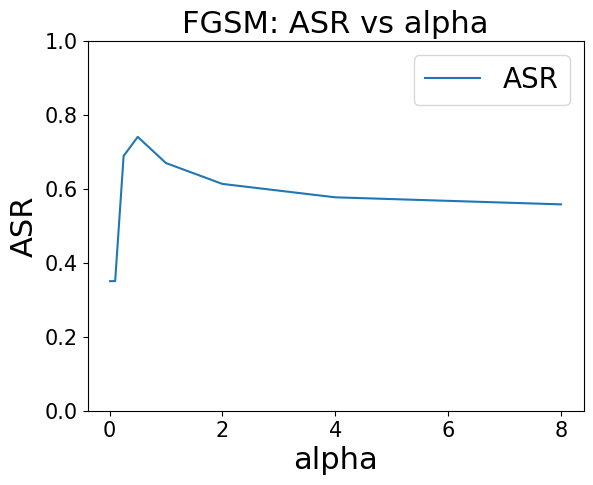

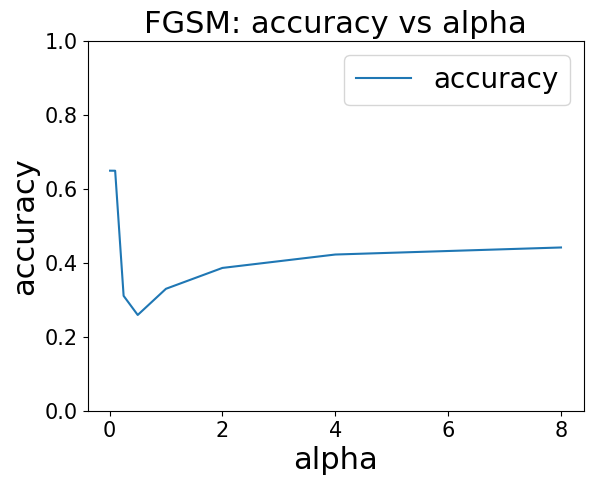

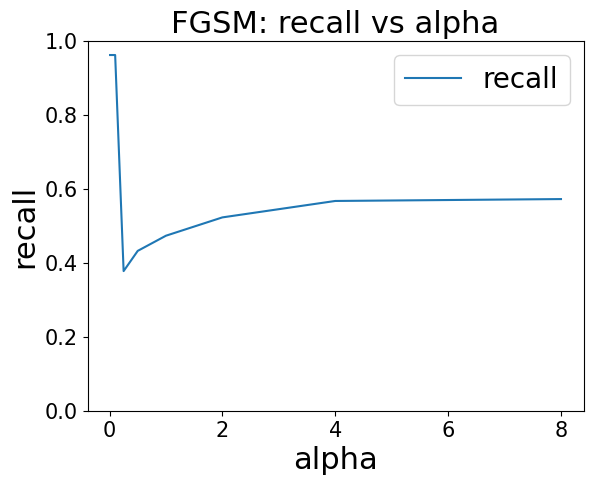

In [5]:
alpha_ablation_dict = {}
best_FGSM_ASR = 0 # best ASR for FGSM
for result, result_file in zip(FGSM_results, FGSM_results_files):
    alpha = float(result_file.split('_')[4])
    result_raw_metrics = [result[r] for r in result]
    true_labels = [r['true_label'] for r in result_raw_metrics]
    predicted_labels = [r['perturbed_text_pred'] > thresh for r in result_raw_metrics]

    # l (0-1) loss - 1 if true != predicted
    l_loss = [int(true != pred) for true, pred in zip(true_labels, predicted_labels)]
    ASR = np.mean(l_loss)
    accuracy = accuracy_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    alpha_ablation_dict[alpha] = {'ASR': ASR, 'accuracy': accuracy, 'recall': recall}

    if ASR > best_FGSM_ASR:
        best_FGSM_ASR = ASR
    print(f'alpha: {alpha}, ASR: {ASR}, accuracy: {accuracy}, recall: {recall}')


alpha_ablation_dict = dict(sorted(alpha_ablation_dict.items()))
alphas = list(alpha_ablation_dict.keys())
ASRs = [alpha_ablation_dict[a]['ASR'] for a in alphas]
accuracies = [alpha_ablation_dict[a]['accuracy'] for a in alphas]
recalls = [alpha_ablation_dict[a]['recall'] for a in alphas]

# plot ASR
plt.plot(alphas, ASRs, label='ASR')
plt.xlabel('alpha')
plt.ylabel('ASR')
plt.ylim(0, 1)
plt.title('FGSM: ASR vs alpha')
plt.legend()
plt.show()

# plot accuracy
plt.plot(alphas, accuracies, label='accuracy')
plt.xlabel('alpha')
plt.ylabel('accuracy')
plt.ylim(0, 1)
plt.title('FGSM: accuracy vs alpha')
plt.legend()
plt.show()

# plot recall
plt.plot(alphas, recalls, label='recall')
plt.xlabel('alpha')
plt.ylabel('recall')
plt.ylim(0, 1)
plt.title('FGSM: recall vs alpha')
plt.legend()
plt.show()

# ModernBERT FGSM Alphas Results

In [6]:
# load pickled results
FGSM_results = []
FGSM_results_files = []
for result_file in result_files:
    if 'FGSM' in result_file and 'ModernBERT-base' in result_file:
        with open(results_path + result_file, 'rb') as f:
            FGSM_results.append(pickle.load(f))
            FGSM_results_files.append(result_file)

alpha: 0.01, ASR: 0.5100031259768678, accuracy: 0.48999687402313225, recall: 0.976068376068376
alpha: 0.1, ASR: 0.5100031259768678, accuracy: 0.48999687402313225, recall: 0.976068376068376
alpha: 0.25, ASR: 0.5104720225070335, accuracy: 0.48952797749296656, recall: 0.976068376068376
alpha: 0.5, ASR: 0.6134729603000938, accuracy: 0.3865270396999062, recall: 0.9282051282051282
alpha: 1.0, ASR: 0.51734917161613, accuracy: 0.48265082838386997, recall: 0.7794871794871795
alpha: 2.0, ASR: 0.46436386370740856, accuracy: 0.5356361362925914, recall: 0.7367521367521368
alpha: 4.0, ASR: 0.4424820256330103, accuracy: 0.5575179743669897, recall: 0.7521367521367521
alpha: 8.0, ASR: 0.4326351984995311, accuracy: 0.5673648015004689, recall: 0.7555555555555555


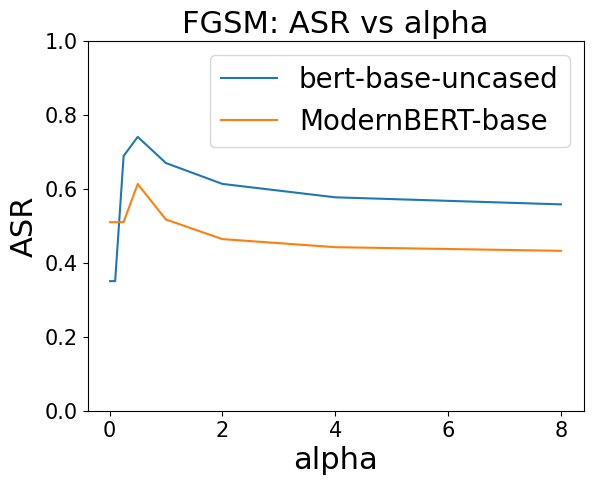

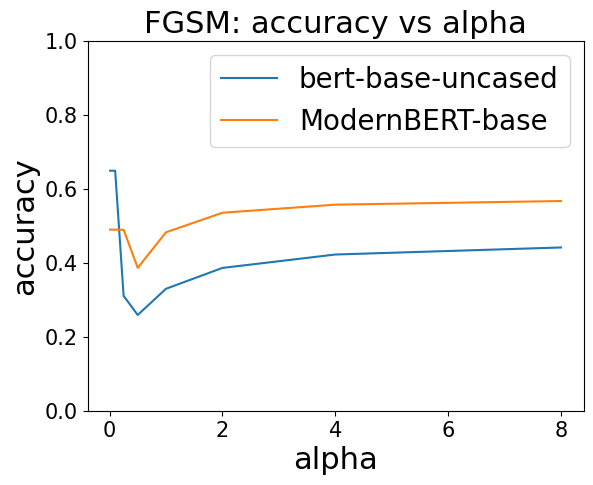

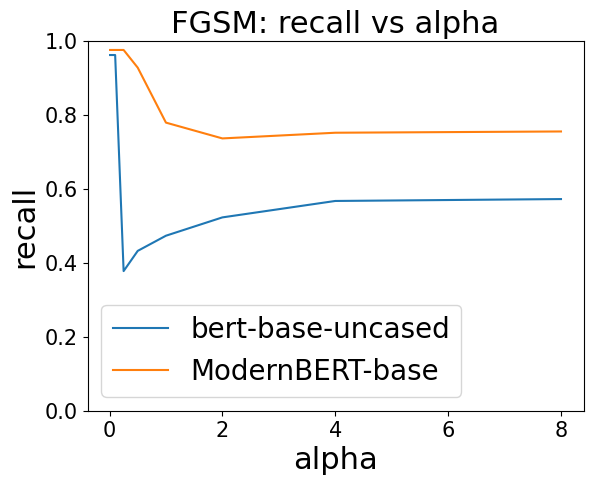

In [7]:
alpha_ablation_dict = {}
for result, result_file in zip(FGSM_results, FGSM_results_files):
    alpha = float(result_file.split('_')[4])
    result_raw_metrics = [result[r] for r in result]
    true_labels = [r['true_label'] for r in result_raw_metrics]
    predicted_labels = [r['perturbed_text_pred'] > thresh for r in result_raw_metrics]

    # l (0-1) loss - 1 if true != predicted
    l_loss = [int(true != pred) for true, pred in zip(true_labels, predicted_labels)]
    ASR = np.mean(l_loss)
    accuracy = accuracy_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    alpha_ablation_dict[alpha] = {'ASR': ASR, 'accuracy': accuracy, 'recall': recall}
    print(f'alpha: {alpha}, ASR: {ASR}, accuracy: {accuracy}, recall: {recall}')


alpha_ablation_dict = dict(sorted(alpha_ablation_dict.items()))
alphas = list(alpha_ablation_dict.keys())
modernBERT_ASRs = [alpha_ablation_dict[a]['ASR'] for a in alphas]
modernBERT_accuracies = [alpha_ablation_dict[a]['accuracy'] for a in alphas]
modernBERT_recalls = [alpha_ablation_dict[a]['recall'] for a in alphas]

# plot ASR
plt.plot(alphas, ASRs, label='bert-base-uncased')
plt.plot(alphas, modernBERT_ASRs, label='ModernBERT-base')
plt.xlabel('alpha')
plt.ylabel('ASR')
plt.ylim(0, 1)
plt.title('FGSM: ASR vs alpha')
plt.legend()
plt.show()

# plot accuracy
plt.plot(alphas, accuracies, label='bert-base-uncased')
plt.plot(alphas, modernBERT_accuracies, label='ModernBERT-base')
plt.xlabel('alpha')
plt.ylabel('accuracy')
plt.ylim(0, 1)
plt.title('FGSM: accuracy vs alpha')
plt.legend()
plt.show()

# plot recall
plt.plot(alphas, recalls, label='bert-base-uncased')
plt.plot(alphas, modernBERT_recalls, label='ModernBERT-base')
plt.xlabel('alpha')
plt.ylabel('recall')
plt.ylim(0, 1)
plt.title('FGSM: recall vs alpha')
plt.legend()
plt.show()

# PGD Alphas Results

In [8]:
# load pickled results
PGD_results = []
PGD_results_files = []
alphas = []
for result_file in result_files:
    # for now, to filter other proceeding experiments from here
    if 'PGD' in result_file and len(result_file.split('_')) == 6 and 'bert-base-uncased' in result_file:
        with open(results_path + result_file, 'rb') as f:
            PGD_results.append(pickle.load(f))
            PGD_results_files.append(result_file)
            alpha = float(result_file.split('_')[4])
            alphas.append(alpha)

# sort results and files by alphas in ascending order
PGD_results = [result for _, result in sorted(zip(alphas, PGD_results))]
PGD_results_files = [result_file for _, result_file in sorted(zip(alphas, PGD_results_files))]
alphas = sorted(alphas)

alpha: 0.01, ASR: 0.3505315822388993, accuracy: 0.6494684177611006, recall: 0.9623931623931624
alpha: 0.1, ASR: 0.37570356472795496, accuracy: 0.624296435272045, recall: 0.9521367521367521
alpha: 0.25, ASR: 0.48639774859287055, accuracy: 0.5136022514071295, recall: 0.9162393162393162
alpha: 0.5, ASR: 0.5920888055034397, accuracy: 0.4079111944965603, recall: 0.8205128205128205
alpha: 1.0, ASR: 0.6832395247029394, accuracy: 0.31676047529706064, recall: 0.7025641025641025
alpha: 2.0, ASR: 0.7424953095684803, accuracy: 0.2575046904315197, recall: 0.5794871794871795
alpha: 4.0, ASR: 0.7801751094434022, accuracy: 0.21982489055659787, recall: 0.49572649572649574
alpha: 8.0, ASR: 0.806910569105691, accuracy: 0.19308943089430894, recall: 0.39145299145299145


alpha: 10.0, ASR: 0.8136335209505942, accuracy: 0.18636647904940587, recall: 0.37264957264957266
alpha: 20.0, ASR: 0.8184803001876173, accuracy: 0.18151969981238275, recall: 0.31965811965811963
alpha: 30.0, ASR: 0.8094121325828643, accuracy: 0.1905878674171357, recall: 0.294017094017094


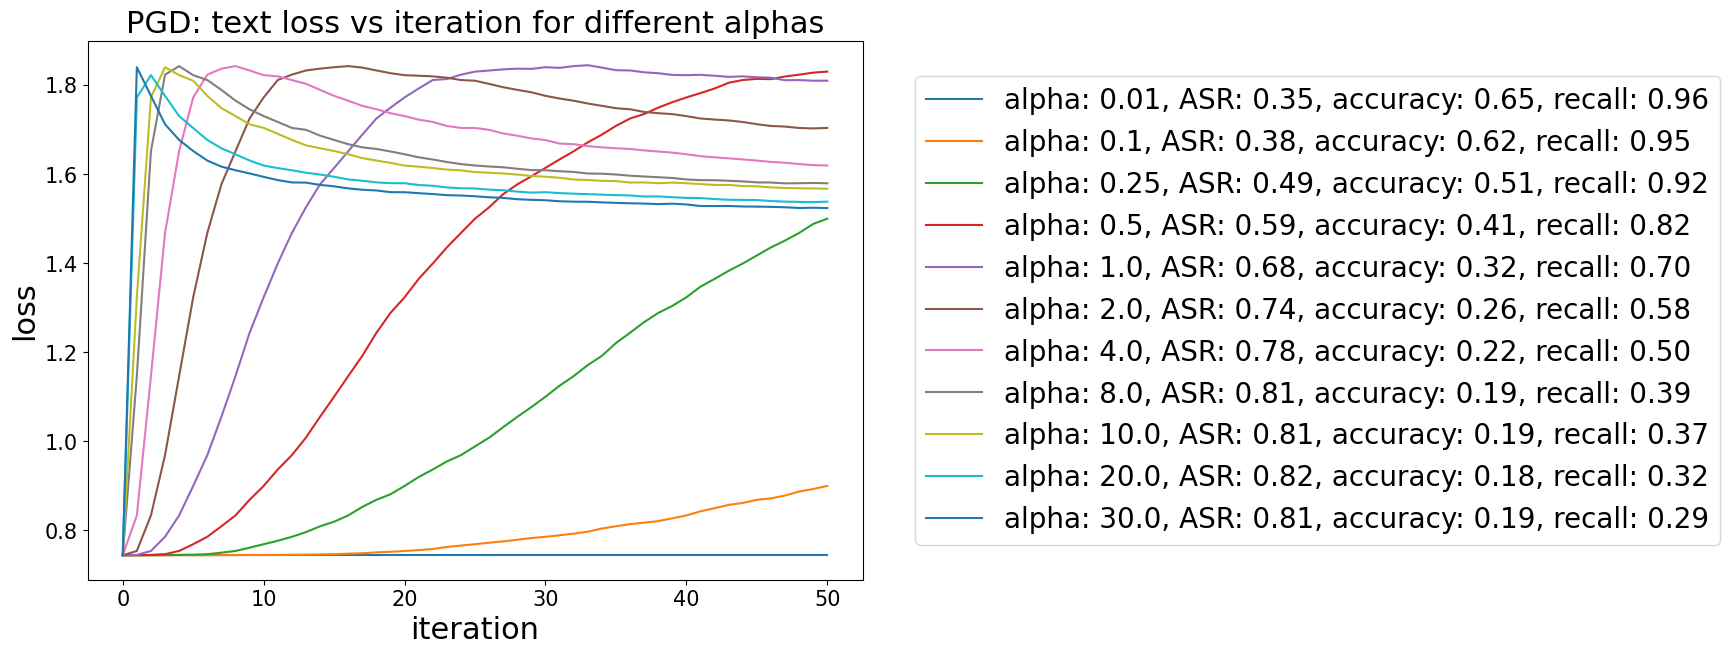

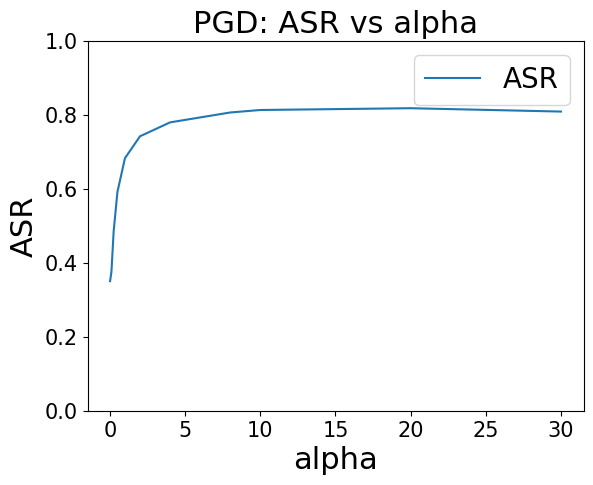

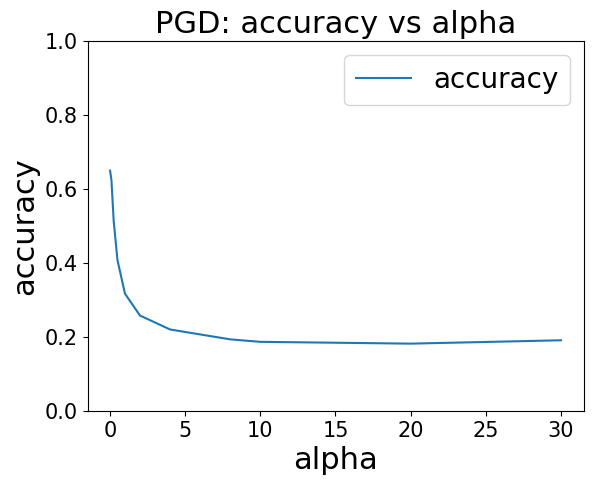

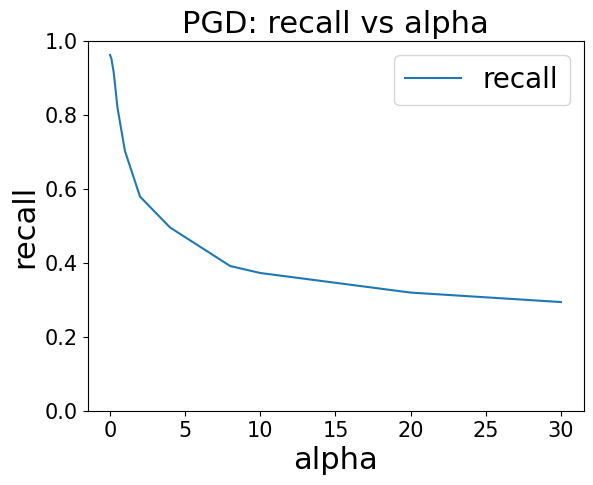

In [9]:
alpha_ablation_dict = {}
best_PGD_wo_emb_proj_ASR = 0
# make the plot long horizontally
plt.figure(figsize=(10, 7))
for result, result_file in zip(PGD_results, PGD_results_files):
    alpha = float(result_file.split('_')[4])
    result_raw_metrics = [result[r] for r in result]
    true_labels = [r['true_label'] for r in result_raw_metrics]
    predicted_labels = [r['perturbed_text_pred'] > thresh for r in result_raw_metrics]

    # l (0-1) loss - 1 if true != predicted
    l_loss = [int(true != pred) for true, pred in zip(true_labels, predicted_labels)]
    ASR = np.mean(l_loss)
    accuracy = accuracy_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    alpha_ablation_dict[alpha] = {'ASR': ASR, 'accuracy': accuracy, 'recall': recall}

    if ASR > best_PGD_wo_emb_proj_ASR:
        best_PGD_wo_emb_proj_ASR = ASR

    print(f'alpha: {alpha}, ASR: {ASR}, accuracy: {accuracy}, recall: {recall}')

    try:
        loss_lists = np.array([r['loss_list'] for r in result_raw_metrics])
    except:
        continue
    mean_loss_list = np.mean(loss_lists, axis=0)
    # plot loss vs iterations
    plt.plot(mean_loss_list, label=f'alpha: {alpha}, ASR: {ASR:.2f}, accuracy: {accuracy:.2f}, recall: {recall:.2f}')
PGD_best_results = PGD_results[-1]

plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('PGD: text loss vs iteration for different alphas')
# put legend outside of plot on the right
plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
plt.show()

alpha_ablation_dict = dict(sorted(alpha_ablation_dict.items()))
alphas = list(alpha_ablation_dict.keys())
ASRs = [alpha_ablation_dict[a]['ASR'] for a in alphas]
accuracies = [alpha_ablation_dict[a]['accuracy'] for a in alphas]
recalls = [alpha_ablation_dict[a]['recall'] for a in alphas]

# plot ASR
plt.plot(alphas, ASRs, label='ASR')
plt.xlabel('alpha')
plt.ylabel('ASR')
plt.ylim(0, 1)
plt.title('PGD: ASR vs alpha')
plt.legend()
plt.show()

# plot accuracy
plt.plot(alphas, accuracies, label='accuracy')
plt.xlabel('alpha')
plt.ylabel('accuracy')
plt.ylim(0, 1)
plt.title('PGD: accuracy vs alpha')
plt.legend()
plt.show()

# plot recall
plt.plot(alphas, recalls, label='recall')
plt.xlabel('alpha')
plt.ylabel('recall')
plt.ylim(0, 1)
plt.title('PGD: recall vs alpha')
plt.legend()
plt.show()

### Printing Examples For Fun

In [10]:
count = 0
for i, (k, v) in enumerate(PGD_best_results.items()):
    if v['true_label'] == 0:
        continue
    print('label: ', v['true_label'])
    print(k)
    print(v['perturbed_text'])
    print(f"Original Pred: {v['original_text_pred']}")
    print(f"Perturbed Pred: {v['perturbed_text_pred']}")

    count += 1
    if count == 50:
        break

label:  1
apologies of a father!!! i apologise on behalf of my son, who is mentally retarded ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! !
apologies of a father!!! i apologise on behalf of my son, who is mentally retarded! timer secret secret forgot forgot forgot forgot forgot forgot forgot forgot forgot forgot forgot forgot forgot dream forget scouts
Original Pred: 0.8440403938293457
Perturbed Pred: 0.03331950306892395
label:  1
: : oh yes and you will burn in hell for trying to steal korean land. fuck you you fucking nip. ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! !
: : oh yes and you will burn in hell for trying to steal korean land. fuck you you fucking nip.! ~!!!!!!!!!!!!!!! ~ event closed
Original Pred: 0.9974108338356018
Perturbed Pred: 0.554142415523529
label:  1
: : you ' re all dishonest weirdos on the english wiki ( why??????!?!?!? ~ ~ ~ ~ ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! !
: : you ' re all dishonest weirdos on the english wiki ( why??????!?!?!? ~ ~ ~ ~! party party program progra

### WordCloud

In [11]:
from wordcloud import WordCloud


# PGD text projection frequency

## With Embedding Projection

In [12]:
# load pickled results
PGD_freq_emb_results = []
PGD_freq_emb_results_files = []
text_proj_freqs = []
for result_file in result_files:
    splitted = result_file.split('_')
    # for now, to filter other proceeding experiments from here
    if 'PGD' in result_file and len(splitted) == 8 and splitted[6] == "True" and 'bert-base-uncased' in result_file:
        print(result_file)
        with open(results_path + result_file, 'rb') as f:
            PGD_freq_emb_results.append(pickle.load(f))
            PGD_freq_emb_results_files.append(result_file)
            text_proj_freq = float(splitted[5])
            text_proj_freqs.append(text_proj_freq)

# sort results and files by text_proj_freqs in ascending order
PGD_freq_emb_results = [result for _, result in sorted(zip(text_proj_freqs, PGD_freq_emb_results))]
PGD_freq_emb_results_files = [result_file for _, result_file in sorted(zip(text_proj_freqs, PGD_freq_emb_results_files))]
text_proj_freqs = sorted(text_proj_freqs)

bert-base-uncased_toxic_classification_PGD_2.0_1_True_results.pkl
bert-base-uncased_toxic_classification_PGD_2.0_5_True_results.pkl
bert-base-uncased_toxic_classification_PGD_2.0_10_True_results.pkl
bert-base-uncased_toxic_classification_PGD_2.0_20_True_results.pkl
bert-base-uncased_toxic_classification_PGD_2.0_15_True_results.pkl
bert-base-uncased_toxic_classification_PGD_2.0_25_True_results.pkl


text_proj_freq: 1.0, ASR: 0.8042526579111945, accuracy: 0.1957473420888055, recall: 0.4666666666666667
text_proj_freq: 5.0, ASR: 0.898217636022514, accuracy: 0.10178236397748593, recall: 0.09230769230769231
text_proj_freq: 10.0, ASR: 0.8994684177611006, accuracy: 0.10053158223889931, recall: 0.09743589743589744
text_proj_freq: 15.0, ASR: 0.900093808630394, accuracy: 0.099906191369606, recall: 0.09401709401709402
text_proj_freq: 20.0, ASR: 0.9004065040650406, accuracy: 0.09959349593495935, recall: 0.09401709401709402
text_proj_freq: 25.0, ASR: 0.9002501563477173, accuracy: 0.09974984365228268, recall: 0.09572649572649573


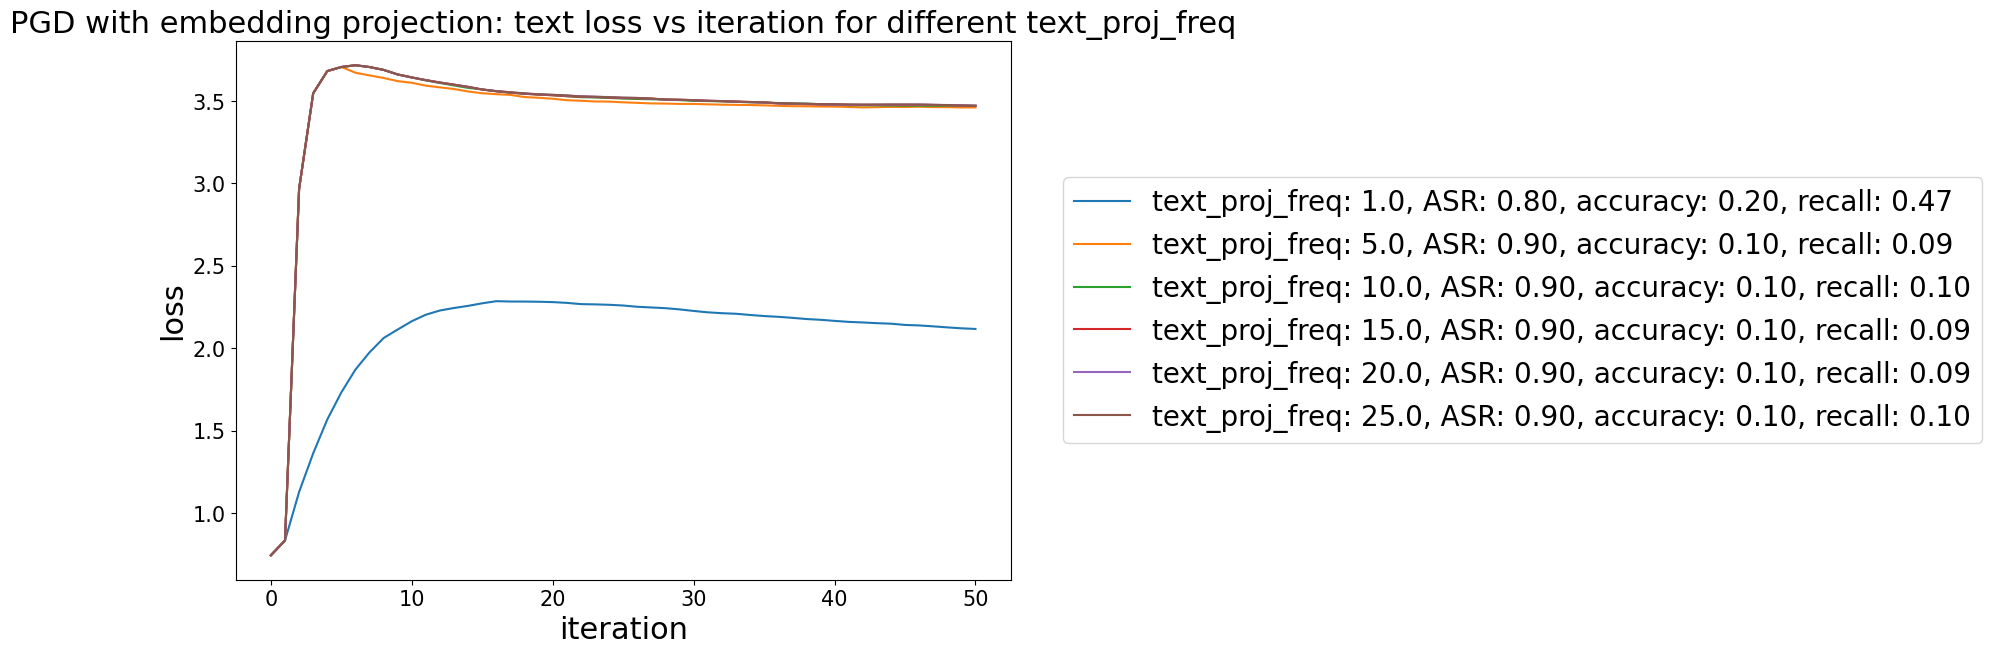

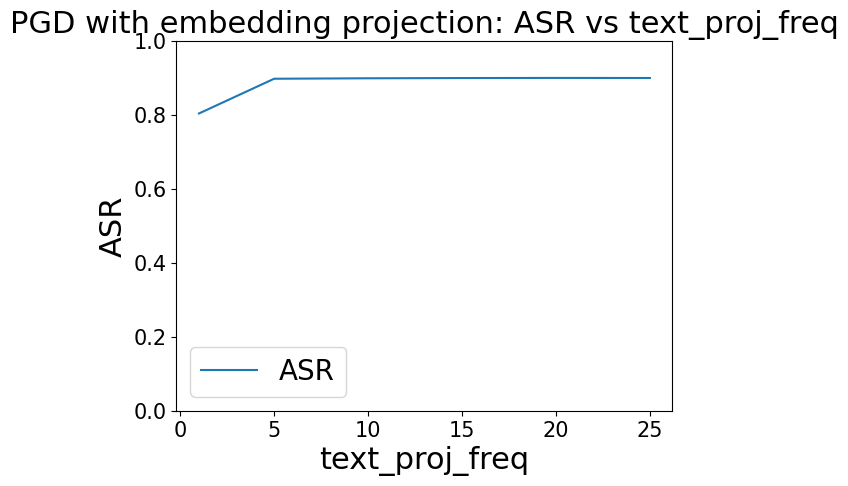

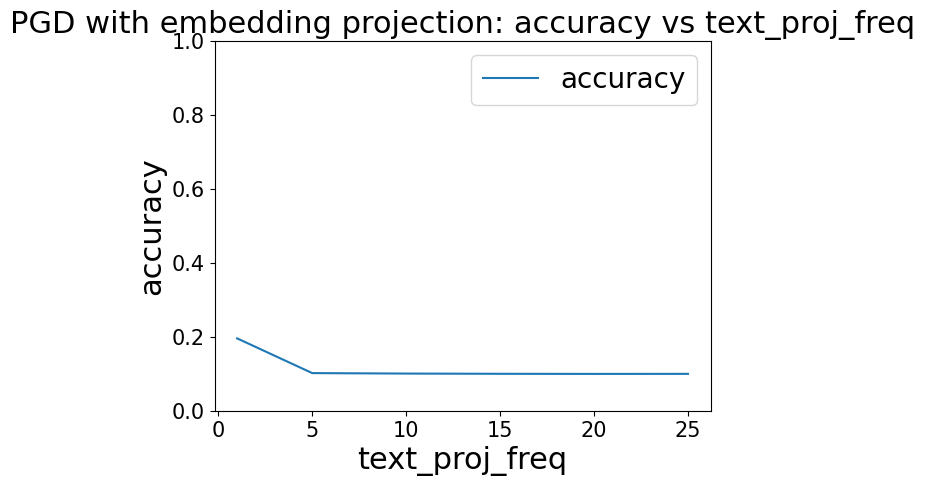

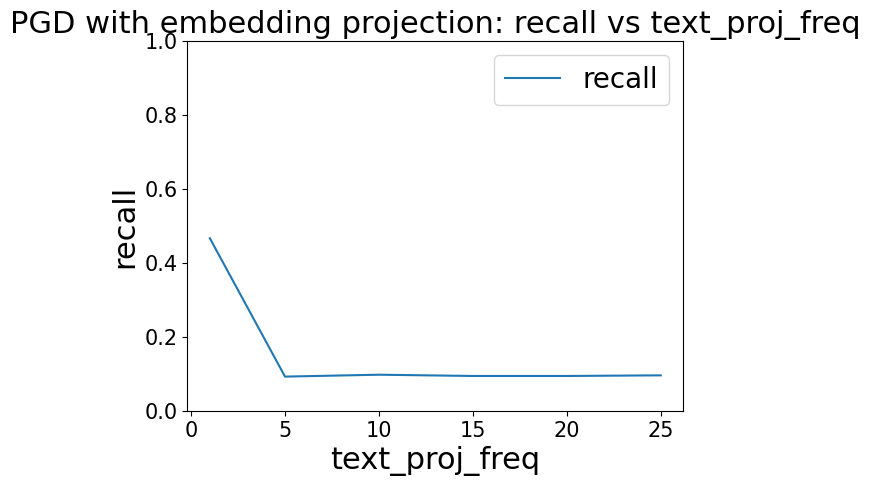

In [13]:
proj_ablation_dict = {}
best_ASR = 0
best_result = None
best_PGD_w_emb_proj_ASR = 0
# make the plot long horizontally
plt.figure(figsize=(10, 7))
for result, result_file in zip(PGD_freq_emb_results, PGD_freq_emb_results_files):
    text_proj_freq = float(result_file.split('_')[5])
    result_raw_metrics = [result[r] for r in result]
    true_labels = [r['true_label'] for r in result_raw_metrics]
    predicted_labels = [r['perturbed_text_pred'] > thresh for r in result_raw_metrics]

    # l (0-1) loss - 1 if true != predicted
    l_loss = [int(true != pred) for true, pred in zip(true_labels, predicted_labels)]
    ASR = np.mean(l_loss)
    accuracy = accuracy_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)

    if ASR > best_PGD_w_emb_proj_ASR:
        best_PGD_w_emb_proj_ASR = ASR 

    proj_ablation_dict[text_proj_freq] = {'ASR': ASR, 'accuracy': accuracy, 'recall': recall}
    print(f'text_proj_freq: {text_proj_freq}, ASR: {ASR}, accuracy: {accuracy}, recall: {recall}')


    if ASR > best_ASR:
        best_ASR = ASR
        best_result = result

    try:
        loss_lists = np.array([r['loss_list'] for r in result_raw_metrics])
    except:
        continue
    mean_loss_list = np.mean(loss_lists, axis=0)
    # plot loss vs iterations
    plt.plot(mean_loss_list, label=f'text_proj_freq: {text_proj_freq}, ASR: {ASR:.2f}, accuracy: {accuracy:.2f}, recall: {recall:.2f}')

plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('PGD with embedding projection: text loss vs iteration for different text_proj_freq')
# put legend outside of plot on the right
plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
plt.show()

proj_ablation_dict = dict(sorted(proj_ablation_dict.items()))
text_proj_freqs = list(proj_ablation_dict.keys())
ASRs = [proj_ablation_dict[a]['ASR'] for a in text_proj_freqs]
accuracies = [proj_ablation_dict[a]['accuracy'] for a in text_proj_freqs]
recalls = [proj_ablation_dict[a]['recall'] for a in text_proj_freqs]

# plot ASR
plt.plot(text_proj_freqs, ASRs, label='ASR')
plt.xlabel('text_proj_freq')
plt.ylabel('ASR')
plt.ylim(0, 1)
plt.title('PGD with embedding projection: ASR vs text_proj_freq')
plt.legend()
plt.show()

# plot accuracy
plt.plot(text_proj_freqs, accuracies, label='accuracy')
plt.xlabel('text_proj_freq')
plt.ylabel('accuracy')
plt.ylim(0, 1)
plt.title('PGD with embedding projection: accuracy vs text_proj_freq')
plt.legend()
plt.show()

# plot recall
plt.plot(text_proj_freqs, recalls, label='recall')
plt.xlabel('text_proj_freq')
plt.ylabel('recall')
plt.ylim(0, 1)
plt.title('PGD with embedding projection: recall vs text_proj_freq')
plt.legend()
plt.show()

### WordCloud

In [14]:
count = 0
all_clean_text = ""
all_perturbed_text = ""
all_suffixes = ""
for i, (k, v) in enumerate(best_result.items()):
    if v['true_label'] == 0:
        continue
    label = v['true_label']
    clean_text = k[:-40]
    perturbed_text = v['perturbed_text']
    clean_pred = v['original_text_pred']
    perturbed_pred = v['perturbed_text_pred']

    all_clean_text += " " + clean_text
    all_perturbed_text += " " + perturbed_text

    all_suffixes += " " + perturbed_text[len(clean_text):]


    # print('label: ', v['true_label'])
    # print(k[:-40])
    # print(v['perturbed_text'])
    # print(f"Clean Pred: {v['original_text_pred']}")
    # print(f"Perturbed Pred: {v['perturbed_text_pred']}")
    count += 1
    if count == 500:
        break

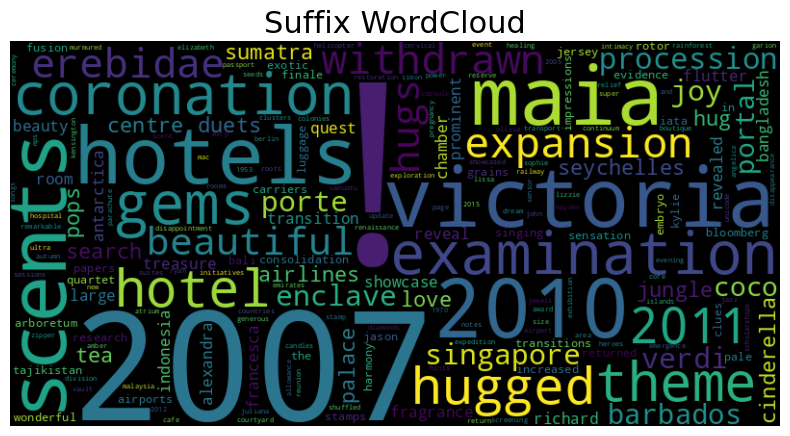

In [15]:
from wordcloud import WordCloud
from collections import Counter

words = all_suffixes.lower().split()
freq_dict = Counter(words)

wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(freq_dict)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Suffix WordCloud')
plt.show()


# PGD text projection frequency in ModernBERT

In [16]:
# load pickled results
PGD_freq_emb_results = []
PGD_freq_emb_results_files = []
text_proj_freqs = []
for result_file in result_files:
    splitted = result_file.split('_')
    # for now, to filter other proceeding experiments from here
    if 'PGD' in result_file and len(splitted) == 8 and splitted[6] == "True" and 'ModernBERT' in result_file:
        print(result_file)
        with open(results_path + result_file, 'rb') as f:
            PGD_freq_emb_results.append(pickle.load(f))
            PGD_freq_emb_results_files.append(result_file)
            text_proj_freq = float(splitted[5])
            text_proj_freqs.append(text_proj_freq)

# sort results and files by text_proj_freqs in ascending order
PGD_freq_emb_results = [result for _, result in sorted(zip(text_proj_freqs, PGD_freq_emb_results))]
PGD_freq_emb_results_files = [result_file for _, result_file in sorted(zip(text_proj_freqs, PGD_freq_emb_results_files))]
text_proj_freqs = sorted(text_proj_freqs)

ModernBERT-base_toxic_classification_PGD_2.0_1_True_results.pkl
ModernBERT-base_toxic_classification_PGD_2.0_5_True_results.pkl
ModernBERT-base_toxic_classification_PGD_2.0_10_True_results.pkl
ModernBERT-base_toxic_classification_PGD_2.0_15_True_results.pkl


ModernBERT-base_toxic_classification_PGD_2.0_20_True_results.pkl
ModernBERT-base_toxic_classification_PGD_2.0_25_True_results.pkl


text_proj_freq: 1.0, ASR: 0.5223507346045639, accuracy: 0.47764926539543606, recall: 0.7623931623931623
text_proj_freq: 5.0, ASR: 0.5597061581744295, accuracy: 0.44029384182557046, recall: 0.4735042735042735
text_proj_freq: 10.0, ASR: 0.5612691466083151, accuracy: 0.4387308533916849, recall: 0.48205128205128206
text_proj_freq: 15.0, ASR: 0.5597061581744295, accuracy: 0.44029384182557046, recall: 0.48034188034188036
text_proj_freq: 20.0, ASR: 0.5601750547045952, accuracy: 0.43982494529540483, recall: 0.4717948717948718
text_proj_freq: 25.0, ASR: 0.5597061581744295, accuracy: 0.44029384182557046, recall: 0.47863247863247865


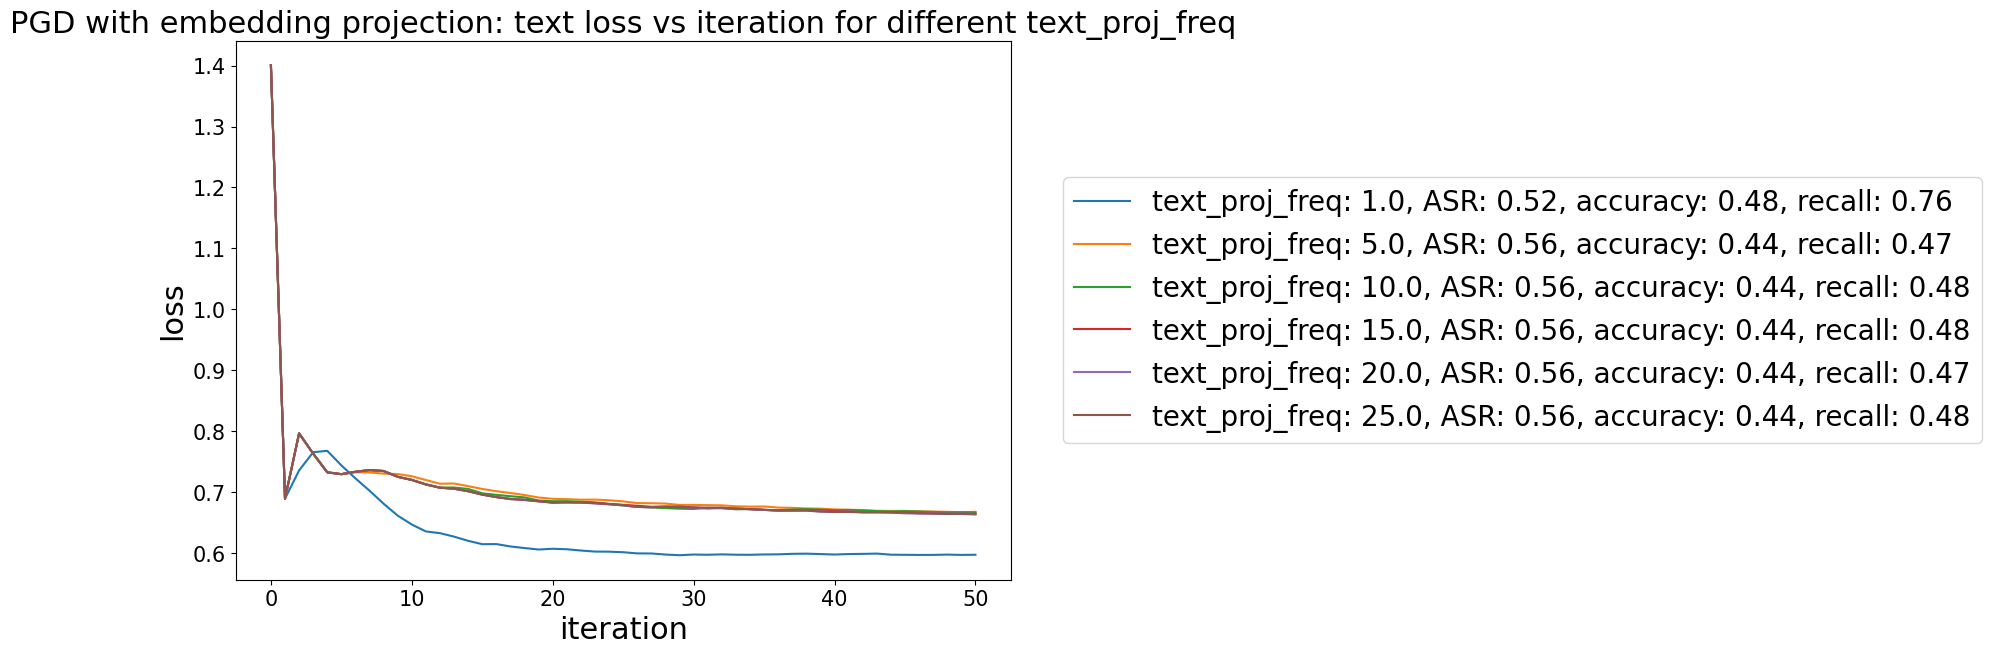

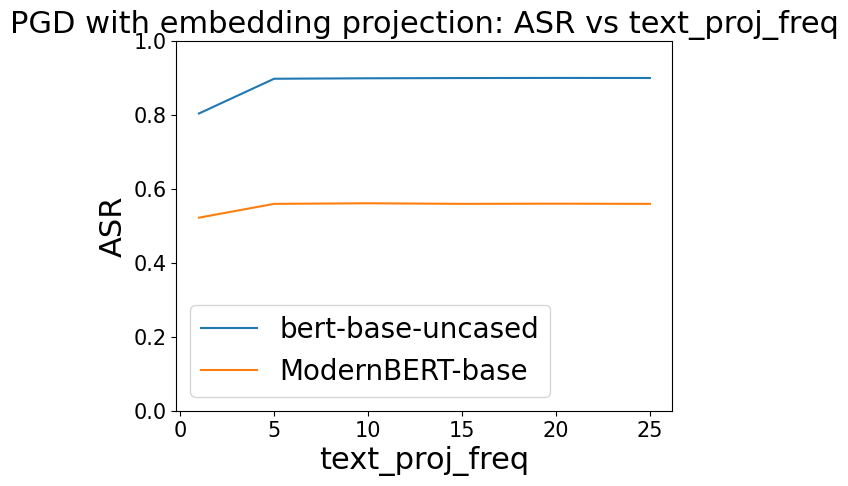

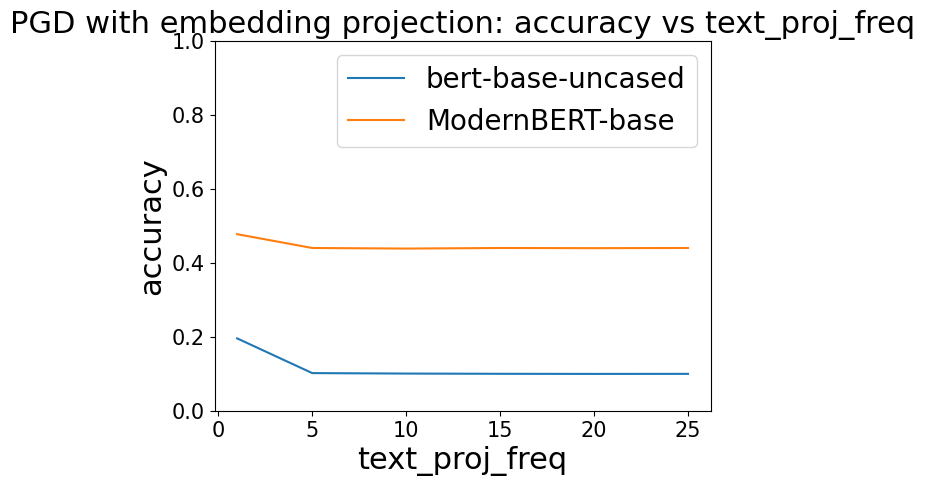

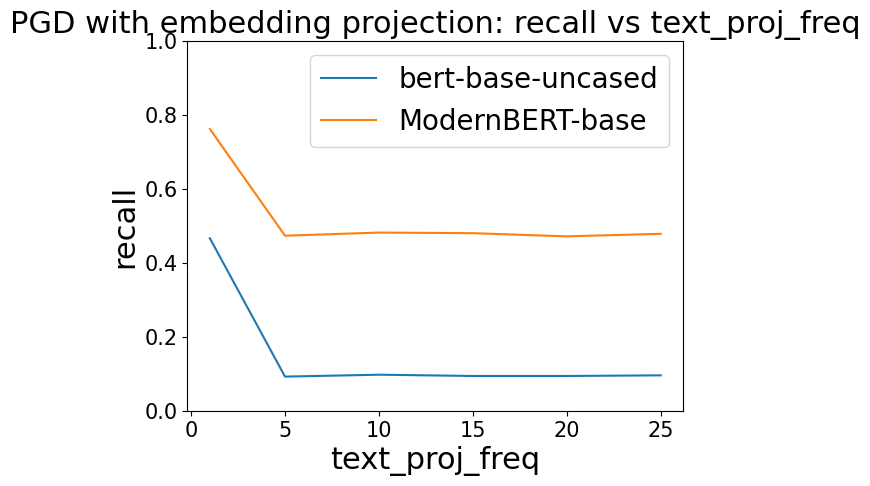

In [17]:
proj_ablation_dict = {}
# make the plot long horizontally
plt.figure(figsize=(10, 7))
for result, result_file in zip(PGD_freq_emb_results, PGD_freq_emb_results_files):
    text_proj_freq = float(result_file.split('_')[5])
    result_raw_metrics = [result[r] for r in result]
    true_labels = [r['true_label'] for r in result_raw_metrics]
    predicted_labels = [r['perturbed_text_pred'] > thresh for r in result_raw_metrics]

    # l (0-1) loss - 1 if true != predicted
    l_loss = [int(true != pred) for true, pred in zip(true_labels, predicted_labels)]
    ASR = np.mean(l_loss)
    accuracy = accuracy_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)

    proj_ablation_dict[text_proj_freq] = {'ASR': ASR, 'accuracy': accuracy, 'recall': recall}
    print(f'text_proj_freq: {text_proj_freq}, ASR: {ASR}, accuracy: {accuracy}, recall: {recall}')

    try:
        loss_lists = np.array([r['loss_list'] for r in result_raw_metrics])
    except:
        continue
    mean_loss_list = np.mean(loss_lists, axis=0)
    # plot loss vs iterations
    plt.plot(mean_loss_list, label=f'text_proj_freq: {text_proj_freq}, ASR: {ASR:.2f}, accuracy: {accuracy:.2f}, recall: {recall:.2f}')

plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('PGD with embedding projection: text loss vs iteration for different text_proj_freq')
# put legend outside of plot on the right
plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
plt.show()

proj_ablation_dict = dict(sorted(proj_ablation_dict.items()))
text_proj_freqs = list(proj_ablation_dict.keys())
modernBERT_ASRs = [proj_ablation_dict[a]['ASR'] for a in text_proj_freqs]
modernBERT_accuracies = [proj_ablation_dict[a]['accuracy'] for a in text_proj_freqs]
modernBERT_recalls = [proj_ablation_dict[a]['recall'] for a in text_proj_freqs]

# plot ASR
plt.plot(text_proj_freqs, ASRs[:len(modernBERT_ASRs)], label='bert-base-uncased')
plt.plot(text_proj_freqs, modernBERT_ASRs, label='ModernBERT-base')
plt.xlabel('text_proj_freq')
plt.ylabel('ASR')
plt.ylim(0, 1)
plt.title('PGD with embedding projection: ASR vs text_proj_freq')
plt.legend()
plt.show()

# plot accuracy
plt.plot(text_proj_freqs, accuracies[:len(modernBERT_accuracies)], label='bert-base-uncased')
plt.plot(text_proj_freqs, modernBERT_accuracies, label='ModernBERT-base')
plt.xlabel('text_proj_freq')
plt.ylabel('accuracy')
plt.ylim(0, 1)
plt.title('PGD with embedding projection: accuracy vs text_proj_freq')
plt.legend()
plt.show()

# plot recall
plt.plot(text_proj_freqs, recalls[:len(modernBERT_recalls)], label='bert-base-uncased')
plt.plot(text_proj_freqs, modernBERT_recalls, label='ModernBERT-base')
plt.xlabel('text_proj_freq')
plt.ylabel('recall')
plt.ylim(0, 1)
plt.title('PGD with embedding projection: recall vs text_proj_freq')
plt.legend()
plt.show()

# Compare All Attacks

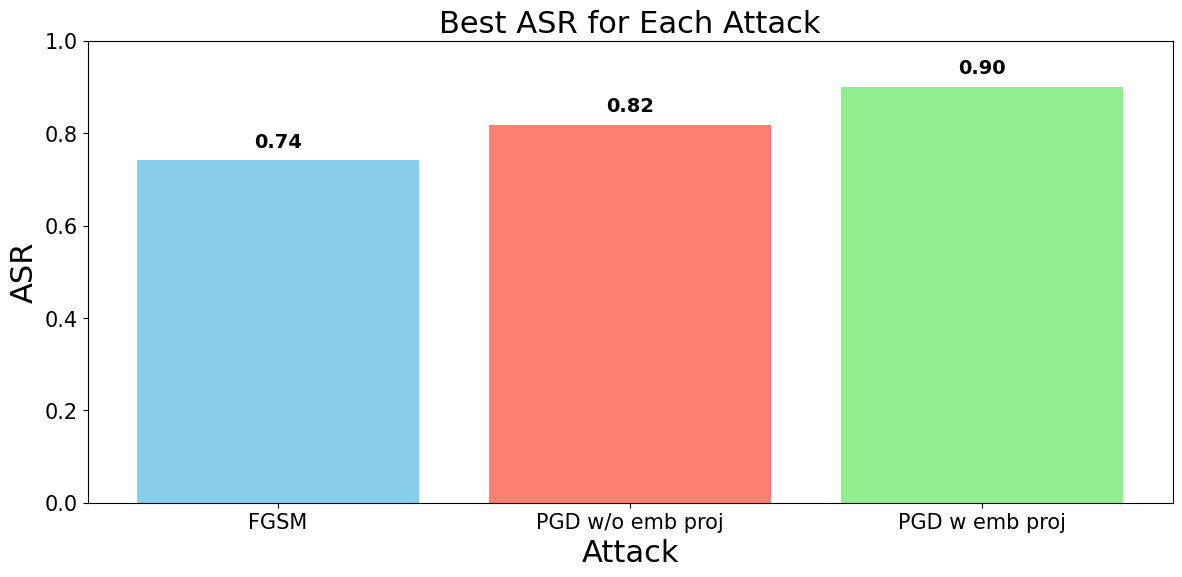

In [18]:
attacks = ['FGSM', 'PGD w/o emb proj', 'PGD w emb proj']
asr_values = [best_FGSM_ASR, best_PGD_wo_emb_proj_ASR, best_PGD_w_emb_proj_ASR]
colors = ['skyblue', 'salmon', 'lightgreen']

plt.figure(figsize=(14, 6))  # long horizontal figure
bars = plt.bar(attacks, asr_values, color=colors)

# Add bold, larger value labels on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        yval + 0.02,
        f'{yval:.2f}',
        ha='center',
        va='bottom',
        fontsize=14,
        fontweight='bold'
    )

plt.xlabel('Attack')
plt.ylabel('ASR')
plt.ylim(0, 1)
plt.title('Best ASR for Each Attack')
plt.show()

# Embedding of Best Attack

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transformer_model = 'bert-base-uncased'
model = AutoModel.from_pretrained(transformer_model, weights_only=True).to(device)
tokenizer = AutoTokenizer.from_pretrained(transformer_model)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.manifold import TSNE
import os
from matplotlib.patches import Patch

# Assumes `best_result`, `get_cls_token_embedding`, `model`, `tokenizer`, `device` are already defined

result = best_result



all_original_text = [r for r in result][:1000]
all_perturbed_text = [result[r]['perturbed_text'] for r in result][:1000]
all_clean_labels = [result[r]['true_label'] for r in result][:1000]
all_perturbed_labels = [result[r]['perturbed_text_pred'] > 0.5 for r in result][:1000]

suffix_size = 20

# === Compute embeddings for the entire dataset ===
print("Computing embeddings for the entire dataset...")
clean_cls_embeddings = [
    get_cls_token_embedding(text[:-suffix_size*2], model, tokenizer, device) 
    for text in all_original_text
]
perturbed_cls_embeddings = [
    get_cls_token_embedding(text, model, tokenizer, device) 
    for text in all_perturbed_text
]

# Convert embeddings to numpy arrays
clean_cls_embeddings = np.array([emb.cpu().detach().numpy().squeeze() for emb in clean_cls_embeddings])
perturbed_cls_embeddings = np.array([emb.cpu().detach().numpy().squeeze() for emb in perturbed_cls_embeddings])

# Convert labels
clean_labels = np.array(all_clean_labels).astype(int)
perturbed_labels = np.array(all_perturbed_labels).astype(int)

# Combine embeddings and labels for all samples
all_embeddings = np.concatenate((clean_cls_embeddings, perturbed_cls_embeddings))
all_labels = np.concatenate((clean_labels, perturbed_labels))

# === Train SVM on all data ===
print("Training SVM on all data...")
svm = SVC(kernel='linear')
svm.fit(all_embeddings, all_labels)
svm_scores = svm.decision_function(all_embeddings)  # decision function on all data

# === Compute 1D t-SNE for visualization (optional but nice) ===
print("Computing t-SNE...")
tsne = TSNE(n_components=1, random_state=0)
tsne_values = tsne.fit_transform(all_embeddings).squeeze()

# === Sampling num_samples toxic examples for visualization ===
num_samples = 30
toxic_indices = [i for i, label in enumerate(clean_labels) if label == 1]
random_indices = np.random.choice(toxic_indices, num_samples, replace=False)
perturbed_indices = random_indices + len(clean_labels)  # offset for perturbed samples

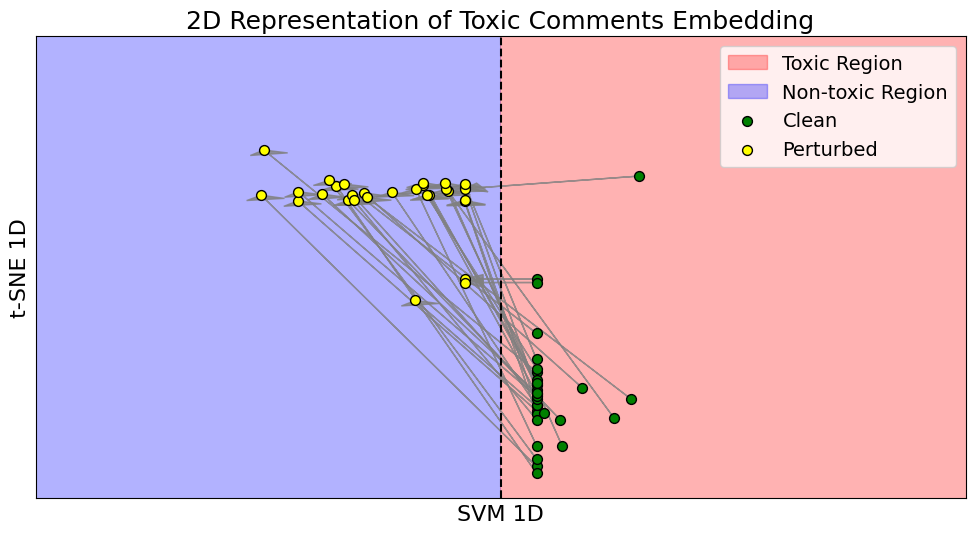

In [ ]:

# === Plotting ===
max_abs_x = max(abs(svm_scores.min() - 1), abs(svm_scores.max() + 1))
x_min, x_max = -max_abs_x, max_abs_x
y_min, y_max = tsne_values.min() - 1, tsne_values.max() + 1

# Create meshgrid for background coloring
x_values = np.linspace(x_min, x_max, 500)
y_values = np.linspace(y_min, y_max, 500)
xx, yy = np.meshgrid(x_values, y_values)
regions = np.where(xx < 0, -1, 1)

# Define colors
non_toxic_color = "#0000FF"  # Blue
toxic_color = "#FF0000"      # Red
clean_color = "#008000"      # Green
perturbed_color = "#FFFF00"  # Yellow

plt.figure(figsize=(12, 6))
plt.title("2D Representation of Toxic Comments Embedding", fontsize=18)

# Plot background regions
plt.contourf(xx, yy, regions, levels=[-2, 0, 2],
             colors=[non_toxic_color, toxic_color], alpha=0.3)

# Draw arrows connecting clean and perturbed points for sampled indices
for clean_idx, perturbed_idx in zip(random_indices, perturbed_indices):
    dx = svm_scores[perturbed_idx] - svm_scores[clean_idx]
    dy = tsne_values[perturbed_idx] - tsne_values[clean_idx]
    plt.arrow(
        svm_scores[clean_idx], tsne_values[clean_idx],
        dx, dy,
        head_width=0.02 * (y_max - y_min),
        head_length=0.02 * (x_max - x_min),
        length_includes_head=True,
        color="gray",
        linestyle="-",
        alpha=0.8,
        zorder=1
    )

# Scatter clean and perturbed points for sampled indices
clean_points = plt.scatter(svm_scores[random_indices], tsne_values[random_indices],
                           color=clean_color, marker="o", s=50, label="Clean", edgecolors="k", zorder=2)
perturbed_points = plt.scatter(svm_scores[perturbed_indices], tsne_values[perturbed_indices],
                               color=perturbed_color, marker="o", s=50, label="Perturbed", edgecolors="k", zorder=2)

# Draw SVM decision boundary
plt.axvline(x=0, color="black", linestyle="--", zorder=3)

plt.xlabel("SVM 1D", fontsize=16)
plt.ylabel("t-SNE 1D", fontsize=16)
plt.xticks([])
plt.yticks([])
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

region_legend_elements = [
    Patch(facecolor=toxic_color, edgecolor=toxic_color, alpha=0.3, label="Toxic Region"),
    Patch(facecolor=non_toxic_color, edgecolor=non_toxic_color, alpha=0.3, label="Non-toxic Region"),
    clean_points,
    perturbed_points
]

plt.legend(handles=region_legend_elements, loc="upper right", fontsize=14)

# Save the plot if needed
# if not os.path.exists("plots/"):
#     os.makedirs("plots/")
# plt.savefig("plots/svm_tsne_toxic_nontoxic_full_train_subset_plot.pdf", bbox_inches='tight')

plt.show()

# OLD

In [ ]:
# load pickled results
results = []
for result_file in result_files:
    with open(results_path + result_file, 'rb') as f:
        results.append(pickle.load(f))

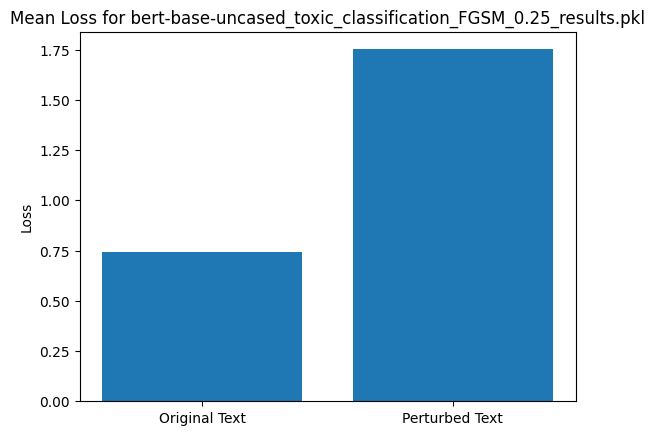

Original Accuracy: 0.6494684177611006
Perturbed Accuracy: 0.31081926203877425
Original Recall: 0.9623931623931624
Perturbed Recall: 0.37777777777777777


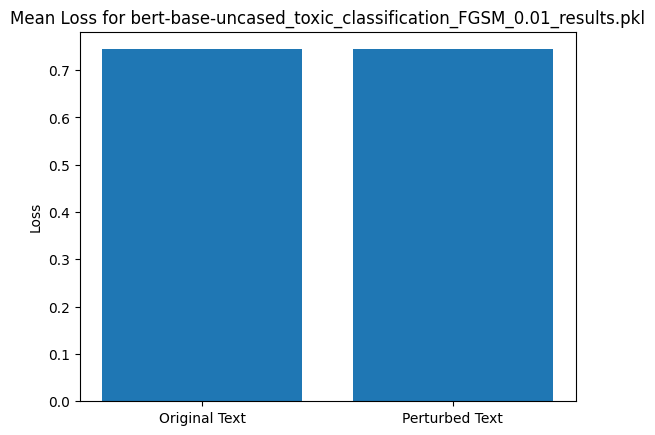

Original Accuracy: 0.6494684177611006
Perturbed Accuracy: 0.6494684177611006
Original Recall: 0.9623931623931624
Perturbed Recall: 0.9623931623931624


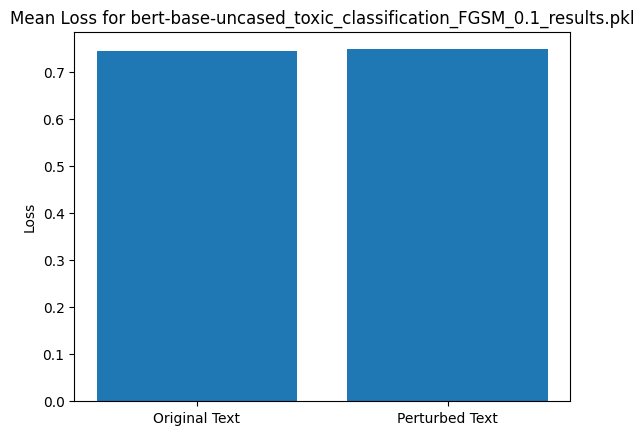

Original Accuracy: 0.6494684177611006
Perturbed Accuracy: 0.6493120700437773
Original Recall: 0.9623931623931624
Perturbed Recall: 0.9623931623931624


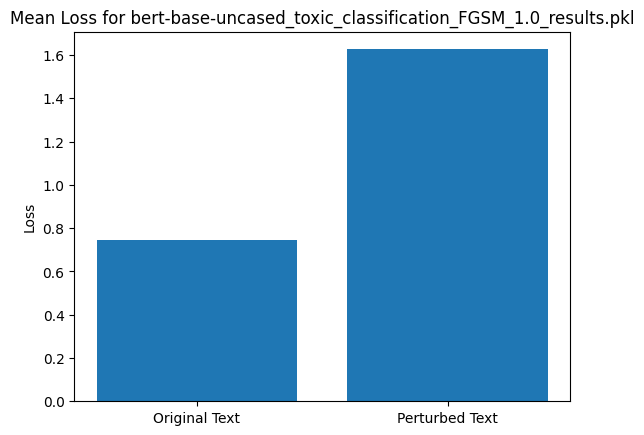

Original Accuracy: 0.6494684177611006
Perturbed Accuracy: 0.32989368355222015
Original Recall: 0.9623931623931624
Perturbed Recall: 0.4735042735042735


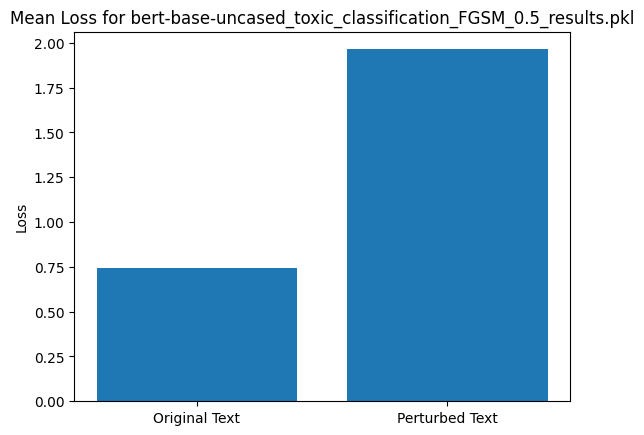

Original Accuracy: 0.6494684177611006
Perturbed Accuracy: 0.259068167604753
Original Recall: 0.9623931623931624
Perturbed Recall: 0.4324786324786325


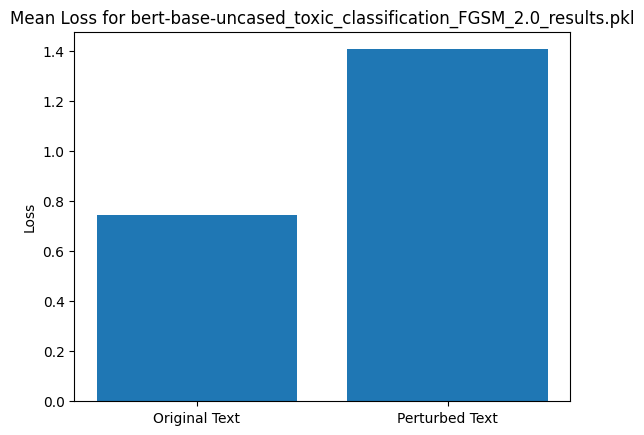

Original Accuracy: 0.6494684177611006
Perturbed Accuracy: 0.3863352095059412
Original Recall: 0.9623931623931624
Perturbed Recall: 0.5230769230769231


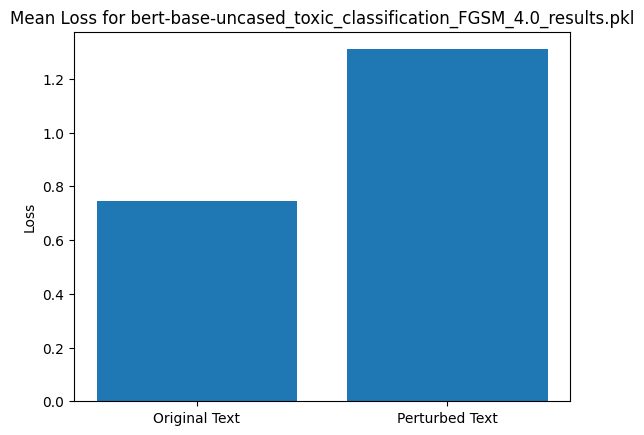

Original Accuracy: 0.6494684177611006
Perturbed Accuracy: 0.4226078799249531
Original Recall: 0.9623931623931624
Perturbed Recall: 0.5675213675213675


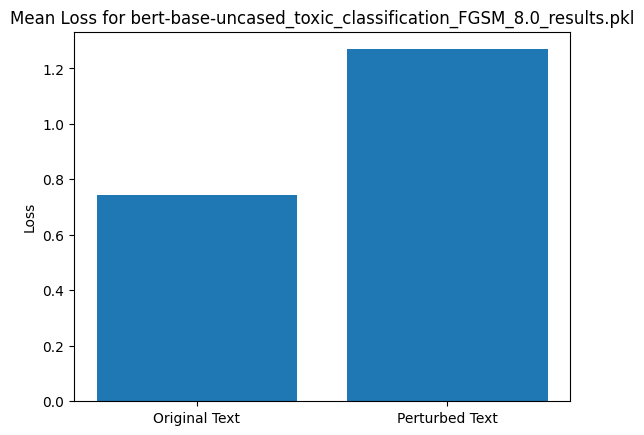

Original Accuracy: 0.6494684177611006
Perturbed Accuracy: 0.441682301438399
Original Recall: 0.9623931623931624
Perturbed Recall: 0.5726495726495726


In [ ]:
for result, result_file in zip(results, result_files):
    result_raw_metrics = [result[r] for r in result]
    mean_original_text_loss = np.mean([r['original_text_loss'] for r in result_raw_metrics])
    mean_perturbed_text_loss = np.mean([r['perturbed_text_loss'] for r in result_raw_metrics]) # change to perturbed_text_loss

    # bar plot
    fig, ax = plt.subplots()
    ax.bar(['Original Text', 'Perturbed Text'], [mean_original_text_loss, mean_perturbed_text_loss])
    ax.set_ylabel('Loss')
    ax.set_title('Mean Loss for ' + result_file)
    plt.show()

    true_labels = [r['true_label'] for r in result_raw_metrics]
    thresh = 0.5
    original_pred_labels = [r['original_text_pred'] > thresh for r in result_raw_metrics]
    perturbed_pred_labels = [r['perturbed_text_pred'] > thresh for r in result_raw_metrics]

    # imports
    # accuracy
    original_accuracy = accuracy_score(true_labels, original_pred_labels)
    perturbed_accuracy = accuracy_score(true_labels, perturbed_pred_labels)

    # recall
    original_recall = recall_score(true_labels, original_pred_labels)
    perturbed_recall = recall_score(true_labels, perturbed_pred_labels)

    print('Original Accuracy:', original_accuracy)
    print('Perturbed Accuracy:', perturbed_accuracy)
    print('Original Recall:', original_recall)
    print('Perturbed Recall:', perturbed_recall)

In [ ]:
count = 0
for i, (k, v) in enumerate(results[0].items()):
    if v['true_label'] == 0:
        continue
    print('label: ', v['true_label'])
    print(k)
    print(v['perturbed_text'])
    print(v['original_text_pred'])
    print(v['perturbed_text_pred'])

    count += 1
    if count == 10:
        break

label:  1
apologies of a father!!! i apologise on behalf of my son, who is mentally retarded ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! !
apologies of a father!!! i apologise on behalf of my son, who is mentally retarded! 2d manor smile mystery mystery wish promise concepts! forgot object object memory memory memory 2 am (!
0.8440403938293457
0.3228527307510376
label:  1
: : oh yes and you will burn in hell for trying to steal korean land. fuck you you fucking nip. ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! !
: : oh yes and you will burn in hell for trying to steal korean land. fuck you you fucking nip.! | event ~ ~ event event event event event event event ~ ~ event avalon vanguard ~ project publication
0.9974108338356018
0.6801586747169495
label:  1
: : you ' re all dishonest weirdos on the english wiki ( why??????!?!?!? ~ ~ ~ ~ ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! ! !
: : you ' re all dishonest weirdos on the english wiki ( why??????!?!?!? ~ ~ ~ ~! power event system story function function pr

## Visualize Embeddings

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transformer_model = 'bert-base-uncased'
model = AutoModel.from_pretrained(transformer_model, weights_only=True).to(device)
tokenizer = AutoTokenizer.from_pretrained(transformer_model)

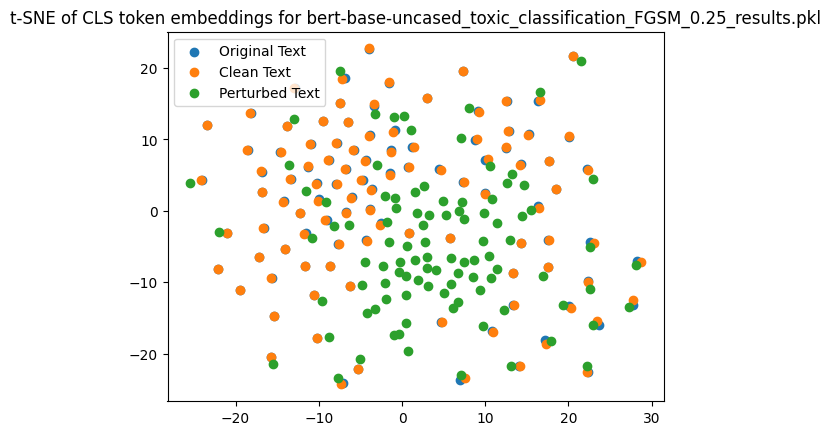

In [ ]:
for result, result_file in zip(results, result_files):
    all_original_text = [r for r in result]
    all_perturbed_text = [result[r]['perturbed_text'] for r in result]
    num_samples = 100
    # sample 100 random samples
    random_indices = np.random.choice(len(all_original_text), num_samples, replace=False)

    original_text_samples = [all_original_text[i] for i in random_indices]
    suffix_size = 20
    clean_text_samples = [original[:-suffix_size] for original in original_text_samples]
    perturbed_text_samples = [all_perturbed_text[i] for i in random_indices]

    # get embeddings of CLS token
    original_cls_embeddings = []
    clean_cls_embeddings = []
    perturbed_cls_embeddings = []
    for original_text, clean_text, perturbed_text in zip(original_text_samples, clean_text_samples, perturbed_text_samples):
        original_cls_embeddings.append(get_cls_token_embedding(original_text, model, tokenizer, device))
        clean_cls_embeddings.append(get_cls_token_embedding(clean_text, model, tokenizer, device))
        perturbed_cls_embeddings.append(get_cls_token_embedding(perturbed_text, model, tokenizer, device))

    # Move the tensors to the CPU and convert them to numpy arrays
    original_cls_embeddings = np.array([embedding.cpu().detach().numpy().squeeze() for embedding in original_cls_embeddings])
    clean_cls_embeddings = np.array([embedding.cpu().detach().numpy().squeeze() for embedding in clean_cls_embeddings])
    perturbed_cls_embeddings = np.array([embedding.cpu().detach().numpy().squeeze() for embedding in perturbed_cls_embeddings])

    # Concatenate original and perturbed embeddings
    all_cls_embeddings = np.concatenate((original_cls_embeddings, clean_cls_embeddings, perturbed_cls_embeddings))

    # Initialize t-SNE
    tsne = TSNE(n_components=2, random_state=0)

    # Perform t-SNE transformation
    all_cls_embeddings_tsne = tsne.fit_transform(all_cls_embeddings)

    # Split the embeddings back into original and perturbed
    original_cls_embeddings_tsne = all_cls_embeddings_tsne[:num_samples]
    clean_cls_embeddings_tsne = all_cls_embeddings_tsne[num_samples:2*num_samples]
    perturbed_cls_embeddings_tsne = all_cls_embeddings_tsne[2*num_samples:]

    # plot
    fig, ax = plt.subplots()
    ax.scatter(original_cls_embeddings_tsne[:, 0], original_cls_embeddings_tsne[:, 1], label='Original Text')
    ax.scatter(clean_cls_embeddings_tsne[:, 0], clean_cls_embeddings_tsne[:, 1], label='Clean Text')
    ax.scatter(perturbed_cls_embeddings_tsne[:, 0], perturbed_cls_embeddings_tsne[:, 1], label='Perturbed Text')
    ax.legend()
    ax.set_title('t-SNE of CLS token embeddings for ' + result_file)
    plt.show()

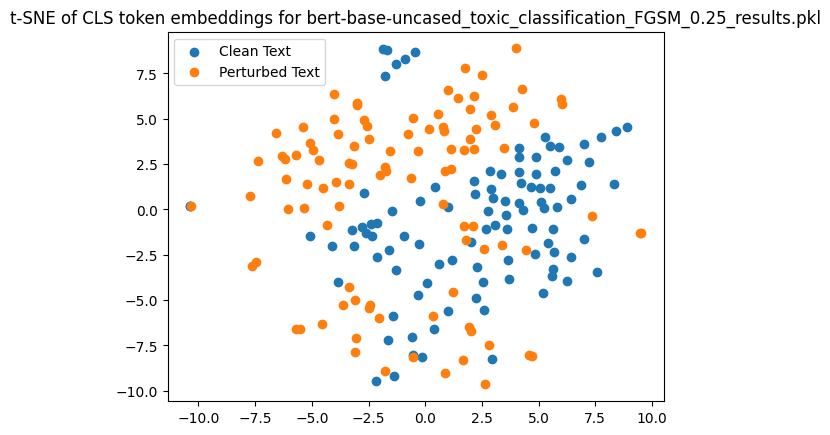

In [ ]:
for result, result_file in zip(results, result_files):
    all_original_text = [r for r in result]
    all_perturbed_text = [result[r]['perturbed_text'] for r in result]
    all_clean_labels = [result[r]['true_label'] for r in result]
    all_perturbed_labels = [result[r]['perturbed_text_pred'] > 0.5 for r in result]

    num_samples = 100
    # sample 100 random samples
    random_indices = np.random.choice(len(all_original_text), num_samples, replace=False)

    suffix_size = 20
    clean_text_samples = [original[:-suffix_size] for original in original_text_samples]
    perturbed_text_samples = [all_perturbed_text[i] for i in random_indices]
    clean_labels_samples = [all_clean_labels[i] for i in random_indices]
    perturbed_labels_samples = [all_perturbed_labels[i] for i in random_indices]

    # get embeddings of CLS token
    original_cls_embeddings = []
    clean_cls_embeddings = []
    perturbed_cls_embeddings = []
    for original_text, clean_text, perturbed_text in zip(original_text_samples, clean_text_samples, perturbed_text_samples):
        clean_cls_embeddings.append(get_cls_token_embedding(clean_text, model, tokenizer, device))
        perturbed_cls_embeddings.append(get_cls_token_embedding(perturbed_text, model, tokenizer, device))

    # Move the tensors to the CPU and convert them to numpy arrays
    clean_cls_embeddings = np.array([embedding.cpu().detach().numpy().squeeze() for embedding in clean_cls_embeddings])
    perturbed_cls_embeddings = np.array([embedding.cpu().detach().numpy().squeeze() for embedding in perturbed_cls_embeddings])

    # Concatenate original and perturbed embeddings
    all_cls_embeddings = np.concatenate((clean_cls_embeddings, perturbed_cls_embeddings))

    # Initialize t-SNE
    tsne = TSNE(n_components=2, random_state=0)

    # Perform t-SNE transformation
    all_cls_embeddings_tsne = tsne.fit_transform(all_cls_embeddings)

    # Split the embeddings back into original and perturbed
    clean_cls_embeddings_tsne = all_cls_embeddings_tsne[:num_samples]
    perturbed_cls_embeddings_tsne = all_cls_embeddings_tsne[num_samples:]

    # plot
    fig, ax = plt.subplots()
    ax.scatter(clean_cls_embeddings_tsne[:, 0], clean_cls_embeddings_tsne[:, 1], label='Clean Text')
    ax.scatter(perturbed_cls_embeddings_tsne[:, 0], perturbed_cls_embeddings_tsne[:, 1], label='Perturbed Text')
    ax.legend()
    ax.set_title('t-SNE of CLS token embeddings for ' + result_file)
    plt.show()

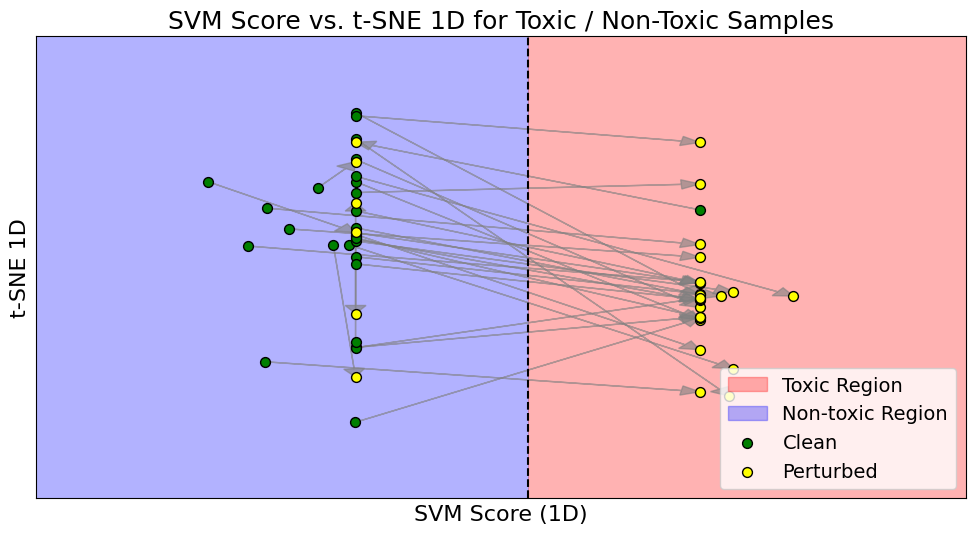

: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.manifold import TSNE
import os
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.patheffects as pe

for result, result_file in zip(results, result_files):
    all_original_text = [r for r in result]
    all_perturbed_text = [result[r]['perturbed_text'] for r in result]
    all_clean_labels = [result[r]['true_label'] for r in result]
    all_perturbed_labels = [result[r]['perturbed_text_pred'] > 0.5 for r in result]

    num_samples = 30
    # sample 100 random samples
    random_indices = np.random.choice(len(all_original_text), num_samples, replace=False)

    suffix_size = 20
    clean_text_samples = [original[:-suffix_size] for original in original_text_samples]
    perturbed_text_samples = [all_perturbed_text[i] for i in random_indices]
    clean_labels_samples = [all_clean_labels[i] for i in random_indices]
    perturbed_labels_samples = [all_perturbed_labels[i] for i in random_indices]

    # get embeddings of CLS token
    clean_cls_embeddings = []
    perturbed_cls_embeddings = []
    for original_text, clean_text, perturbed_text in zip(original_text_samples, clean_text_samples, perturbed_text_samples):
        clean_cls_embeddings.append(get_cls_token_embedding(clean_text, model, tokenizer, device))
        perturbed_cls_embeddings.append(get_cls_token_embedding(perturbed_text, model, tokenizer, device))

    # Move the tensors to the CPU and convert them to numpy arrays
    clean_cls_embeddings = np.array([embedding.cpu().detach().numpy().squeeze() for embedding in clean_cls_embeddings])
    perturbed_cls_embeddings = np.array([embedding.cpu().detach().numpy().squeeze() for embedding in perturbed_cls_embeddings])


    # Convert labels to numpy arrays and ensure they are integers
    clean_labels = np.array(clean_labels_samples).astype(int)
    perturbed_labels = np.array(perturbed_labels_samples).astype(int)

    # Combine embeddings and labels from clean and perturbed samples
    all_embeddings = np.concatenate((clean_cls_embeddings, perturbed_cls_embeddings))
    all_labels = np.concatenate((clean_labels, perturbed_labels))

    # --- Compute 1D t-SNE Embeddings ---
    tsne = TSNE(n_components=1, random_state=0)
    tsne_values = tsne.fit_transform(all_embeddings).squeeze()  # shape: (total_samples,)

    # --- Train a Linear SVM on the 1D t-SNE values ---
    svm = SVC(kernel='linear')
    svm.fit(all_embeddings, all_labels)
    # Get SVM decision function (the signed distance to the hyperplane)
    svm_scores = svm.decision_function(all_embeddings)

    # --- Define Plot Limits ---
    x_min, x_max = svm_scores.min() - 1, svm_scores.max() + 1
    y_min, y_max = tsne_values.min() - 1, tsne_values.max() + 1

    # Create a meshgrid for background region coloring
    x_values = np.linspace(x_min, x_max, 500)
    y_values = np.linspace(y_min, y_max, 500)
    xx, yy = np.meshgrid(x_values, y_values)
    # Here, we assign region based solely on the SVM score (i.e. x-axis value)
    regions = np.where(xx < 0, -1, 1)

    # Define colors for regions and points:
    non_toxic_color = "#0000FF"  # Blue for non-toxic region
    toxic_color = "#FF0000"      # Red for toxic region
    clean_color = "#008000"      # Green for clean points
    perturbed_color = "#FFFF00"  # Yellow for perturbed points

    plt.figure(figsize=(12, 6))
    plt.title("SVM Score vs. t-SNE 1D for Toxic / Non-Toxic Samples", fontsize=18)

    # Plot background regions based on SVM decision function (x < 0: non-toxic, x ≥ 0: toxic)
    plt.contourf(xx, yy, regions, levels=[-2, 0, 2],
                 colors=[non_toxic_color, toxic_color], alpha=0.3)

    # Draw arrows connecting each clean point to its perturbed counterpart
    for i in range(num_samples):
        clean_idx = i
        perturbed_idx = i + num_samples
        dx = svm_scores[perturbed_idx] - svm_scores[clean_idx]
        dy = tsne_values[perturbed_idx] - tsne_values[clean_idx]
        plt.arrow(
            svm_scores[clean_idx], tsne_values[clean_idx],
            dx, dy,
            head_width=0.02 * (y_max - y_min),  # relative arrowhead size
            head_length=0.02 * (x_max - x_min),
            length_includes_head=True,
            color="gray",
            linestyle="-",
            alpha=0.6,
            zorder=1
        )
    # Scatter plot clean and perturbed points with different markers and colors
    clean_points = plt.scatter(svm_scores[:num_samples], tsne_values[:num_samples],
                color=clean_color, marker="o", s=50, label="Clean", edgecolors="k", zorder=2)
    perturbed_points = plt.scatter(svm_scores[num_samples:], tsne_values[num_samples:],
                color=perturbed_color, marker="o", s=50, label="Perturbed", edgecolors="k", zorder=2)

    # Draw SVM decision boundary at x = 0
    plt.axvline(x=0, color="black", linestyle="--", zorder=3, label="SVM Decision Boundary")

    plt.xlabel("SVM Score (1D)", fontsize=16)
    plt.ylabel("t-SNE 1D", fontsize=16)
    plt.xticks([])  # Optionally remove x-ticks
    plt.yticks([])  # Optionally remove y-ticks
    plt.legend(loc="lower right", fontsize=14)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)


    region_legend_elements = [
    Patch(facecolor=toxic_color, edgecolor=toxic_color, alpha=0.3, label="Toxic Region"),
    Patch(facecolor=non_toxic_color, edgecolor=non_toxic_color, alpha=0.3, label="Non-toxic Region"),
    clean_points,
    perturbed_points
    ]

    # Add the legend with all custom elements and increased font size
    plt.legend(handles=region_legend_elements, loc="lower right", fontsize=14)

    # Optionally save the plot as a PDF (uncomment the following lines if needed)
    # if not os.path.exists("plots/"):
    #     os.makedirs("plots/")
    # plt.savefig("plots/svm_tsne_toxic_nontoxic.pdf", bbox_inches='tight')
    plt.show()